Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

2024-04-14 08:23:53.432306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 08:23:53.432398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 08:23:53.555731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("dataset\\Train\\")
data_dir_test = pathlib.Path('dataset\\Train\\')

# data_dir_train = pathlib.Path("/kaggle/input/melenoma-data/dataset/Train")
# data_dir_test = pathlib.Path('/kaggle/input/melenoma-data/dataset/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=42, validation_split=0.3, subset='training', label_mode='categorical')
train_ds

Found 2239 files belonging to 9 classes.
Using 1568 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset='validation', label_mode='categorical')
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

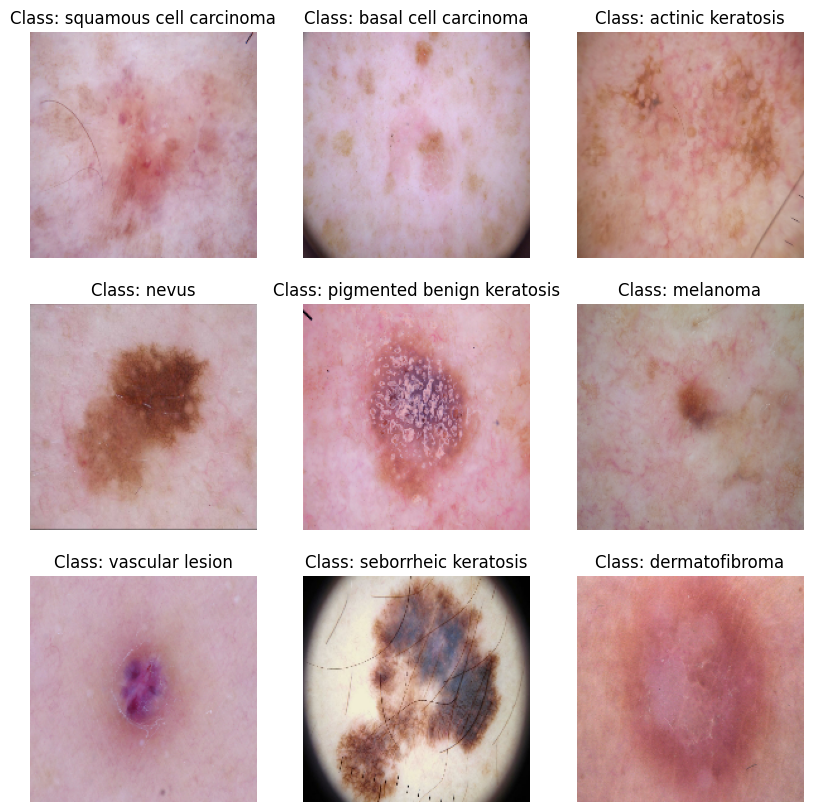

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
class_names = train_ds.class_names

one_hot_encoded_classnames = { class_name: idx for idx,class_name in enumerate(class_names) }
is_label_accounted_flag = [ False for i in range(len(class_names)) ]

fig = plt.figure(figsize=(10,10))
plot_count = 1

for image_batch,one_hot_label_batch in train_ds:
  for image,one_hot_label in zip(image_batch,one_hot_label_batch):
    label = list(one_hot_label.numpy()).index(1)

    if is_label_accounted_flag[label]:
      continue
    
    ax = plt.subplot(3, 3, plot_count)
    ax.imshow(image.numpy().astype(np.uint8))
    ax.axis('off')
    ax.set_title(f"Class: {class_names[label]}")
    
    plot_count += 1
    is_label_accounted_flag[label] = True

    if all(is_label_accounted_flag):
      break

    print()

  if all(is_label_accounted_flag):
      break
        
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
no_of_classes = len(class_names)

model_basic = Sequential((
    layers.Input((180,180,3)),
    
    layers.Rescaling(scale=1./255.),

    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(20, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(no_of_classes, activation='softmax')
))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model_basic.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model_basic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,104,059 (30.91 MB)

 Trainable params: 8,103,779 (30.91 MB)

 Non-trainable params: 280 (1.09 KB)

### Train the model

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
epochs = 40
history = model_basic.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Num GPUs Available:  2
Epoch 1/40
 7/49 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2107 - loss: 2.3492 

I0000 00:00:1713083068.567178      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713083068.586431      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2663 - loss: 2.1488

W0000 00:00:1713083071.824237      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.2673 - loss: 2.1457 - val_accuracy: 0.1499 - val_loss: 2.4334
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4644 - loss: 1.5817 - val_accuracy: 0.1499 - val_loss: 2.5176
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5906 - loss: 1.2791 - val_accuracy: 0.1499 - val_loss: 3.8708
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6525 - loss: 1.0896 - val_accuracy: 0.1499 - val_loss: 5.5558
Epoch 5/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7454 - loss: 0.8666 - val_accuracy: 0.1499 - val_loss: 9.7956
Epoch 6/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8476 - loss: 0.6092 - val_accuracy: 0.1521 - val_loss: 12.2837
Epoch 7/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8910 - loss: 0.4695 - val_accuracy: 0.1544 - val_loss: 14.2692
Epoch 8/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9464 - loss: 0.2894 - val_accuracy: 0.2483 - val_loss

### Visualizing training results

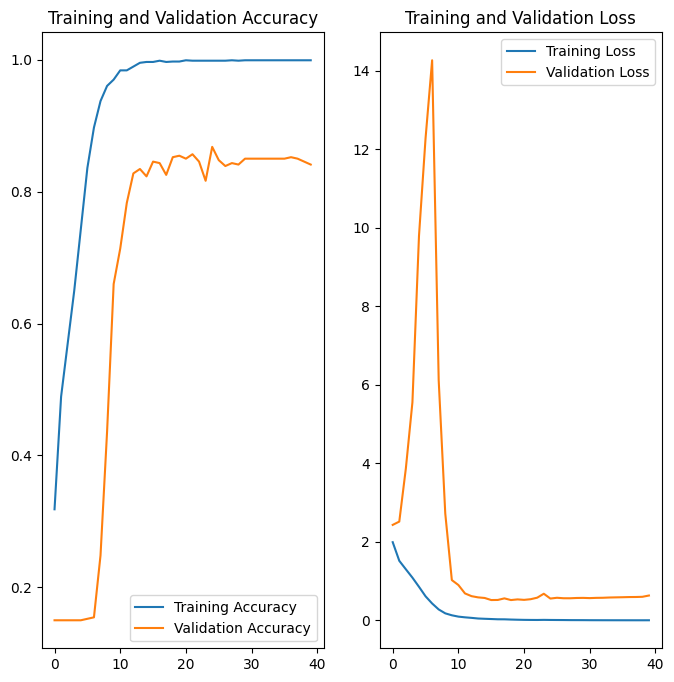

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model does have a bit of overfitting, but the validation accuracy of the model comes out to be <b>close to 85%</b>, which is a good enough model.

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = Sequential((
    layers.RandomFlip(seed=42),
    layers.RandomFlip(seed=144),
#     layers.RandomTranslation(0.025, 0.025, seed=42),
#     layers.RandomZoom((0,-0.025), seed=42),
#     layers.RandomContrast(0.025, seed=42),
#     layers.RandomBrightness(0.025, seed=42),
))

Original Image


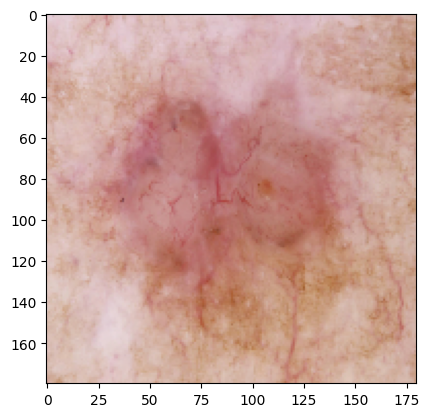


Augmented Images


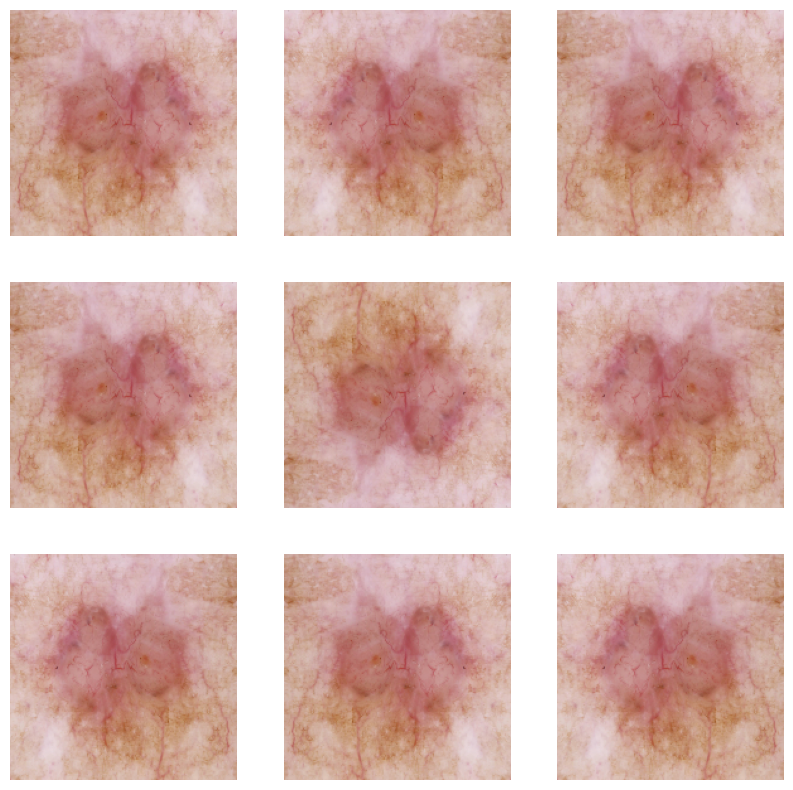

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for image_batch, _ in train_ds:
    org_image = image_batch[0]
    print("Original Image")
    plt.imshow(org_image.numpy().astype("int"))
    plt.show()
    
    print("\nAugmented Images")
    fig, ax = plt.subplots(3, 3, figsize=(10,10))
    for i in range(3):
        for j in range(3):
            aug_image_batch = data_augmentation(image_batch)
            a_aug_image = aug_image_batch[0]
            a_aug_image = a_aug_image.numpy().astype("int")
            
            
            
            ax[i,j].imshow(a_aug_image)
            ax[i,j].axis('off')
            
    plt.show()
    break

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

no_of_classes = len(class_names)

model_with_augmentation = Sequential((
    layers.Input((180,180,3)),
    data_augmentation,
    layers.Rescaling(scale=1./255.),

    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(20, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(no_of_classes, activation='softmax')
))

### Compiling the model

In [19]:
## Your code goes here
model_with_augmentation.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model_with_augmentation.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 90, 90, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 81000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     8,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,104,059 (30.91 MB)

 Trainable params: 8,103,779 (30.91 MB)

 Non-trainable params: 280 (1.09 KB)

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
epochs = 100
history = model_with_augmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Num GPUs Available:  2
Epoch 1/100
 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1250 - loss: 2.7292

W0000 00:00:1713083131.696358      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2035 - loss: 2.3246

W0000 00:00:1713083133.384073      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.2080 - loss: 2.3103 - val_accuracy: 0.1477 - val_loss: 2.2453
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4106 - loss: 1.7000 - val_accuracy: 0.1499 - val_loss: 2.3341
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5002 - loss: 1.4886 - val_accuracy: 0.1499 - val_loss: 2.5236
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5504 - loss: 1.3220 - val_accuracy: 0.1499 - val_loss: 2.4950
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5955 - loss: 1.2252 - val_accuracy: 0.1499 - val_loss: 2.6471
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6345 - loss: 1.1021 - val_accuracy: 0.1611 - val_loss: 2.4440
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6490 - loss: 1.0287 - val_accuracy: 0.2506 - val_loss: 2.1433
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6724 - loss: 0.9745 - val_accuracy: 0.3848 - val_

### Visualizing the results

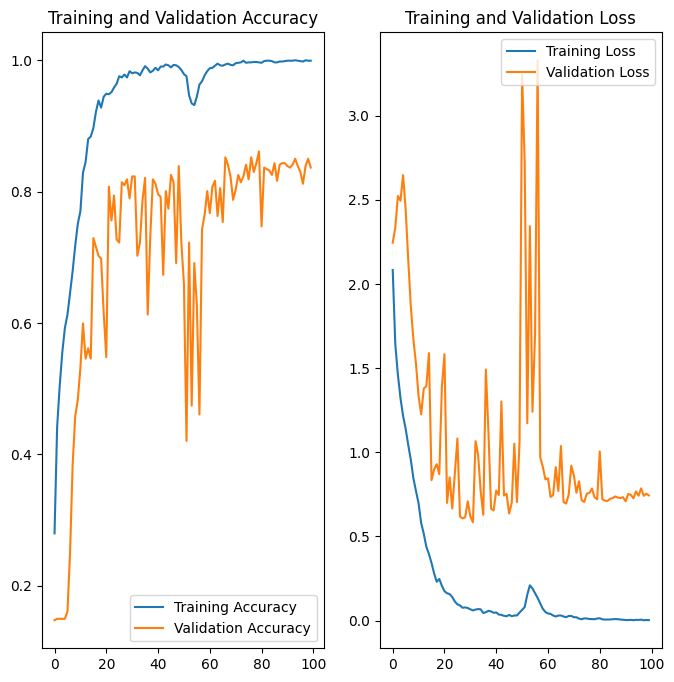

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Here too, the model is overfitting.
And there is no improvement as compared to the model with no data augmentation.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
category_distribution = {}
for cat_dir_pathobj in data_dir_train.iterdir():
    cat_name = cat_dir_pathobj.name
    category_distribution[cat_name] = len(list(cat_dir_pathobj.glob("*.jpg")))
    
category_distribution

{'pigmented benign keratosis': 462,
 'melanoma': 438,
 'vascular lesion': 139,
 'actinic keratosis': 114,
 'squamous cell carcinoma': 181,
 'basal cell carcinoma': 376,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 357}

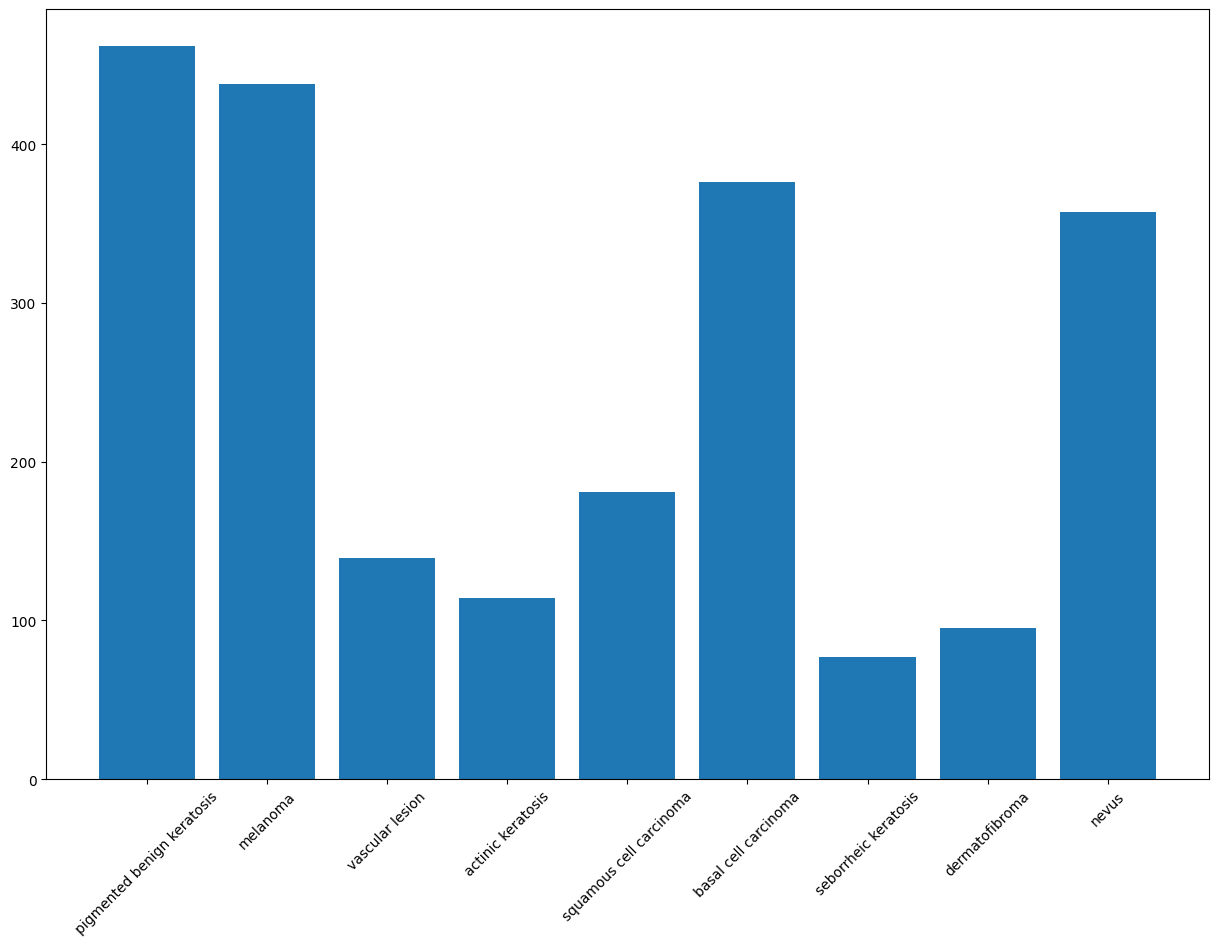

In [24]:
## Your code goes here.
x = []
y = []
for key,val in category_distribution.items():
    x += [key]
    y += [val]
    
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


As can be seen,
- eborrheic keratosis contains the least number of samples
- pigmented benign keratosis, melanoma, basal cell carcinoma, and nevus contains the most amount of data

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [15]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [16]:
path_to_training_dataset="dataset\\Train\\"
import Augmentor
for idv_class_name in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + idv_class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    n_augmented_data_to_create = 500 - category_distribution[idv_class_name]

    print(f"Class: {idv_class_name} | number of samples to create: {n_augmented_data_to_create}")
    p.sample(n_augmented_data_to_create) ## Creating samples such that the total datapoints in each category is 500

Initialised with 114 image(s) found.

Output directory set to dataset\Train\actinic keratosis\output.Class: actinic keratosis | number of samples to create: 386


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D81B29CAD0>: 100%|█| 386/386 [00:03<00:00, 104.43 Samples


Initialised with 376 image(s) found.

Output directory set to dataset\Train\basal cell carcinoma\output.Class: basal cell carcinoma | number of samples to create: 124


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D81B50D590>: 100%|█| 124/124 [00:01<00:


Initialised with 95 image(s) found.

Output directory set to dataset\Train\dermatofibroma\output.Class: dermatofibroma | number of samples to create: 405


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D81CA64550>: 100%|█| 405/405 [00:03<00:


Initialised with 438 image(s) found.

Output directory set to dataset\Train\melanoma\output.Class: melanoma | number of samples to create: 62


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x1D81B50C790>: 100%|█| 62/62 [00:02<00:


Initialised with 357 image(s) found.

Output directory set to dataset\Train\nevus\output.Class: nevus | number of samples to create: 143


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D81B4BC390>: 100%|█| 143/143 [00:06<00:00, 21.73 Samples/


Initialised with 462 image(s) found.

Output directory set to dataset\Train\pigmented benign keratosis\output.Class: pigmented benign keratosis | number of samples to create: 38


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D81B1BA490>: 100%|█| 38/38 [00:00<00:00, 114.11 Samples/s


Initialised with 77 image(s) found.

Output directory set to dataset\Train\seborrheic keratosis\output.Class: seborrheic keratosis | number of samples to create: 423


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D81B539D50>: 100%|█| 423/423 [00:08<00


Initialised with 181 image(s) found.

Output directory set to dataset\Train\squamous cell carcinoma\output.Class: squamous cell carcinoma | number of samples to create: 319


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D81AB7B410>: 100%|█| 319/319 [00:03<00:00, 103.50 Samples


Initialised with 139 image(s) found.

Output directory set to dataset\Train\vascular lesion\output.Class: vascular lesion | number of samples to create: 361


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D81B442610>: 100%|█| 361/361 [00:03<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

#### **Todo**: Train the model on the data created using Augmentor

In [25]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [26]:
data_dir_train = pathlib.Path("dataset\\Train\\")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=42, validation_split=0.3, subset='training', label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 3150 files for training.


#### **Todo:** Create a validation dataset

In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=42, validation_split=0.3, subset='validation', label_mode='categorical')

Found 4500 files belonging to 9 classes.
Using 1350 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [28]:
## your code goes here

no_of_classes = len(train_ds.class_names)

model_trained_on_balanced_data = Sequential((
    layers.Input((180,180,3)),
    layers.Rescaling(scale=1./255.),

    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(20, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(no_of_classes, activation='softmax')
))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [29]:
## your code goes here

model_trained_on_balanced_data.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model_trained_on_balanced_data.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 180, 180, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 180, 180, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 81000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     8,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,104,059 (30.91 MB)

 Trainable params: 8,103,779 (30.91 MB)

 Non-trainable params: 280 (1.09 KB)

#### **Todo:**  Train your model

In [31]:
epochs = 100
history = model_trained_on_balanced_data.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/100
 1/99 ━━━━━━━━━━━━━━━━━━━━ 9:50 6s/step - accuracy: 0.0625 - loss: 3.0160

W0000 00:00:1713083263.519005      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2531 - loss: 2.1258

W0000 00:00:1713083278.982834      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step - accuracy: 0.2537 - loss: 2.1231 - val_accuracy: 0.2133 - val_loss: 2.1120
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.5175 - loss: 1.4163 - val_accuracy: 0.2741 - val_loss: 2.0699
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.6662 - loss: 1.0294 - val_accuracy: 0.1770 - val_loss: 2.2060
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8146 - loss: 0.6663 - val_accuracy: 0.2748 - val_loss: 2.0279
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8969 - loss: 0.4264 - val_accuracy: 0.4444 - val_loss: 1.4679
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9311 - loss: 0.2870 - val_accuracy: 0.5304 - val_loss: 1.3789
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9399 - loss: 0.2289 - val_accuracy: 0.4341 - val_loss: 1.7279
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9434 - loss: 0.2043 - val_accuracy

#### **Todo:**  Visualize the model results

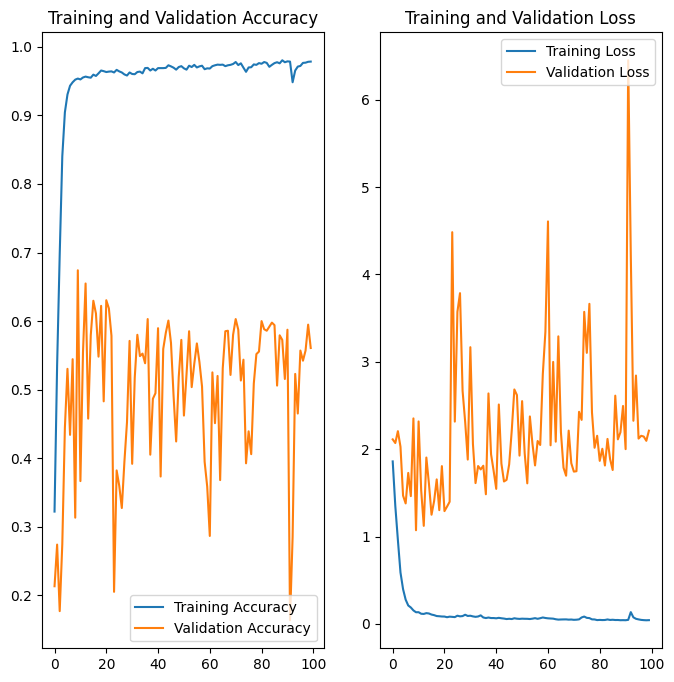

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The model is hugely overfitting. Adding data to rebalance made the model much worse, with validation accuracy of <b>nearly 55%</b>